In [107]:
import pandas as pd
from Metrics import Metrics
from Data import DataCollector
import numpy as np

In [187]:
df = pd.read_csv("data/vdldzmmxjpozcoct.csv")

df = df.drop_duplicates(subset=['date', 'PERMNO', 'RET'])
df.columns

/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_87096/907098666.py:1: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/vdldzmmxjpozcoct.csv")


Index(['PERMNO', 'date', 'SHRCD', 'EXCHCD', 'SICCD', 'TICKER', 'COMNAM',
       'PERMCO', 'FACPR', 'FACSHR', 'DLRET', 'PRC', 'VOL', 'RET', 'SHROUT'],
      dtype='object')

In [206]:
# Show some observations with delisting codes
df[df['DLRET'].notna()][['PERMNO', 'date', 'RET', 'DLRET']].head(20)

,PERMNO,date,RET,DLRET
17,10000,1987-06-30,NaN,0.0
753,10003,1995-12-29,NaN,0.01373
820,10005,1991-07-31,NaN,0.125
970,10006,1984-06-29,NaN,0.035629
1028,10007,1990-10-31,NaN,-0.133333
1063,10008,1988-11-30,NaN,0.009369
1242,10009,2000-11-30,NaN,0.005671
1358,10010,1995-08-31,NaN,-0.112977
1475,10011,1998-02-27,NaN,0.005236
1711,10012,2005-08-31,NaN,-0.058824


/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_87096/173008245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["date"] = pd.to_datetime(test["date"])
/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_87096/173008245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_values("date", inplace = True)


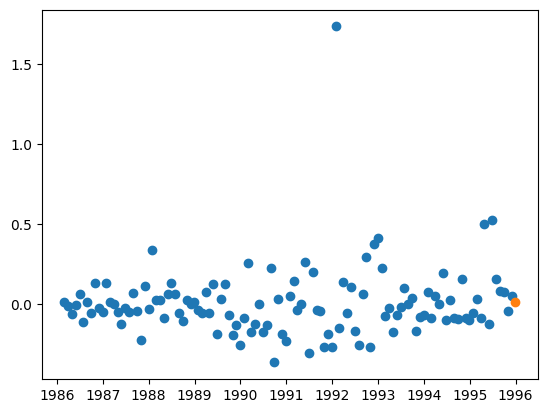

In [238]:
import matplotlib.pyplot as plt

test = df[df["PERMNO"] == 10003]
test["date"] = pd.to_datetime(test["date"])
test.sort_values("date", inplace = True)
test = test[["date", "RET", "DLRET"]][1:]

test["RET"] = pd.to_numeric(test["RET"], errors="coerce")
test["DLRET"] = pd.to_numeric(test["DLRET"], errors="coerce")

test.dtypes


plt.scatter(test["date"], test["RET"], label="RET")
plt.scatter(test["date"], test["DLRET"], label="DLRET")



In [162]:
# There is a single observation where SICCD has a "Z" value
# Remove it to avoid code breaking on cleaning
df = df[df["SICCD"] != "Z"]

In [163]:
df["SICCD"] = df["SICCD"].astype(int)

Notes:
 - Market equity (size). CRSP shrout is usually in **thousands** of shares:

In [164]:
df['date'] = pd.to_datetime(df['date'])

df = df[df["SHRCD"].isin([10, 11])]
df = df[df['SHRCD'] != 12]
df = df[~df['SICCD'].between(6000, 6999)]
df = df[~df['SICCD'].between(6798, 6799)]
df = df[(df['SICCD'] != 6726) & (df['SHRCD'] != 14)]
df = df[df['PRC'] >= 1]

In [113]:
df = df.sort_values(['PERMNO', 'date'])

In [170]:
df['MKTCAP'] = df["PRC"] * df["SHROUT"]
df['MKTCAP'] = df['MKTCAP'] * 1000

# panel = df.copy()
df = df.sort_values(['PERMNO', 'date'])

# CRSP monthly file contains end-of-month observations.
# To get beginning-of-month market cap, use the market cap from the previous month.

df['MKTCAP_BOM'] = df.groupby('PERMNO')['MKTCAP'].shift(1)

def liquidity_filter(df):
    df = df.copy()
    df = df.sort_values("MKTCAP_BOM", ascending = False)

    df['WEIGHT'] = df['MKTCAP_BOM'] / df['MKTCAP_BOM'].sum()

    df['CUM_WEIGHT'] = df['WEIGHT'].cumsum()

    # Flag stocks that fall within the first 90% of total market cap
    df['LIQUID'] = df['CUM_WEIGHT'] <= 0.90
    return df

df = (df.groupby('date', group_keys=False).apply(liquidity_filter))

df = df[df['LIQUID']]
df.sort_values("date")

/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_87096/3969450184.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.groupby('date', group_keys=False).apply(liquidity_filter))


,PERMNO,date,SHRCD,EXCHCD,SICCD,TICKER,COMNAM,PERMCO,FACPR,FACSHR,DLRET,PRC,VOL,RET,SHROUT,MKTCAP,MKTCAP_BOM,WEIGHT,CUM_WEIGHT,LIQUID
244786,12490,1972-02-29,11,1,3573,IBM,INTERNATIONAL BUSINESS MACHS COR,20990,0.0,0.0,NaN,368.500,5001.0,0.005027,114996.0,4.237603e+10,4.231853e+10,0.060890,0.060890,True
341555,17822,1972-02-29,10,1,3843,SYB,SYBRON CORP,22808,0.0,0.0,NaN,37.875,2213.0,0.126667,9608.0,3.639030e+08,3.242700e+08,0.000467,0.833044,True
372346,19254,1972-02-29,11,1,3533,DI,DRESSER INDUSTRIES INC,20600,0.0,0.0,NaN,32.125,1463.0,-0.019623,9764.0,3.136685e+08,3.234325e+08,0.000465,0.833510,True
435070,22189,1972-02-29,10,1,4511,NAL,NATIONAL AIRLINES INC,23124,NaN,NaN,NaN,40.750,2293.0,0.072368,8496.0,3.462120e+08,3.228480e+08,0.000465,0.833974,True
438674,22322,1972-02-29,10,1,3861,BHW,BELL & HOWELL CO,23135,0.0,0.0,NaN,62.750,1064.0,0.050522,5327.0,3.342692e+08,3.189541e+08,0.000459,0.834433,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578281,69550,2011-07-29,11,3,2834,MYL,MYLAN INC,3104,NaN,NaN,NaN,22.780,1064240.0,-0.076611,426263.0,9.710271e+09,1.051324e+10,0.000815,0.713804,True
1662524,75241,2011-07-29,11,1,1311,PXD,PIONEER NATURAL RESOURCES CO,21366,NaN,NaN,NaN,92.990,286877.0,0.038182,116756.0,1.085714e+10,1.045783e+10,0.000811,0.714615,True
103404,10909,2011-07-29,11,3,7373,CERN,CERNER CORP,8786,NaN,NaN,NaN,66.490,217357.0,0.088038,169053.0,1.124033e+10,1.031683e+10,0.000800,0.715416,True
1791281,76744,2011-07-29,11,3,2830,VRTX,VERTEX PHARMACEUTICALS INC,11042,NaN,NaN,NaN,51.860,346003.0,-0.002501,208088.0,1.079144e+10,1.081850e+10,0.000839,0.708867,True


In [171]:
df['RET_VALID'] = df['RET'].notna().astype(int)

In [172]:
df['RET_12M_HIST'] = df.groupby('PERMNO')['RET_VALID'].rolling(12, min_periods=12).sum().reset_index(level=0, drop=True)
df = df[df['RET_12M_HIST'] >= 12]


In [173]:
df.sort_values('date')

,PERMNO,date,SHRCD,EXCHCD,SICCD,TICKER,COMNAM,PERMCO,FACPR,FACSHR,...,VOL,RET,SHROUT,MKTCAP,MKTCAP_BOM,WEIGHT,CUM_WEIGHT,LIQUID,RET_VALID,RET_12M_HIST
244797,12490,1973-01-31,11,1,3573,IBM,INTERNATIONAL BUSINESS MACHS COR,20990,NaN,NaN,...,9451.0,0.083333,116171.0,5.059247e+10,4.670074e+10,0.058944,0.058944,True,1,12.0
835446,40301,1973-01-31,10,1,2661,JWC,WALTER JIM CORP,24450,NaN,NaN,...,3851.0,-0.157895,13654.0,3.550040e+08,4.215672e+08,0.000532,0.824890,True,1,12.0
540426,26294,1973-01-31,11,1,3573,LIT,LITTON INDUSTRIES INC,21109,NaN,NaN,...,10362.0,-0.125000,32438.0,3.689822e+08,4.216940e+08,0.000532,0.824357,True,1,12.0
978756,46201,1973-01-31,10,1,3714,MAE,MONROE AUTO EQUIP CO,24868,NaN,NaN,...,3495.0,-0.053232,12835.0,3.994894e+08,4.219506e+08,0.000533,0.823825,True,1,12.0
512528,25072,1973-01-31,11,1,4911,DQU,DUQUESNE LIGHT CO,20612,NaN,NaN,...,2077.0,0.021505,18150.0,4.310625e+08,4.219875e+08,0.000533,0.823293,True,1,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520827,25320,2011-07-29,11,1,2032,CPB,CAMPBELL SOUP CO,20384,0.0,0.0,...,443657.0,-0.035022,320996.0,1.060892e+10,1.109041e+10,0.000860,0.704645,True,1,12.0
2412713,86799,2011-07-29,11,1,1221,CNX,CONSOL ENERGY INC,35026,NaN,NaN,...,767387.0,0.105611,226695.0,1.215085e+10,1.098741e+10,0.000852,0.705497,True,1,12.0
2609473,91207,2011-07-29,11,1,7011,HOT,STARWOOD HOTELS & REST WLDWD INC,20935,NaN,NaN,...,633620.0,-0.019272,195491.0,1.074419e+10,1.093195e+10,0.000848,0.706345,True,1,12.0
247732,12570,2011-07-29,11,1,3561,ITT,I T T CORP,20964,NaN,NaN,...,227600.0,-0.094858,184100.0,9.819894e+09,1.084901e+10,0.000841,0.708028,True,1,12.0


In [174]:
df.columns
df.head()

,PERMNO,date,SHRCD,EXCHCD,SICCD,TICKER,COMNAM,PERMCO,FACPR,FACSHR,...,VOL,RET,SHROUT,MKTCAP,MKTCAP_BOM,WEIGHT,CUM_WEIGHT,LIQUID,RET_VALID,RET_12M_HIST
244797,12490,1973-01-31,11,1,3573,IBM,INTERNATIONAL BUSINESS MACHS COR,20990,NaN,NaN,...,9451.0,0.083333,116171.0,5.059247e+10,4.670074e+10,0.058944,0.058944,True,1,12.0
47230,10401,1973-01-31,11,1,4811,T,AMERICAN TELEPHONE & TELEG CO,20103,NaN,NaN,...,47269.0,0.000000,553714.0,2.920841e+10,2.920841e+10,0.036866,0.095809,True,1,12.0
191082,11754,1973-01-31,11,1,3861,EK,EASTMAN KODAK CO,20626,NaN,NaN,...,10842.0,-0.050548,161545.0,2.275765e+10,2.396924e+10,0.030253,0.126062,True,1,12.0
222947,12079,1973-01-31,11,1,3711,GM,GENERAL MOTORS CORP,20799,NaN,NaN,...,18852.0,-0.047766,285923.0,2.208755e+10,2.319550e+10,0.029276,0.155338,True,1,12.0
200928,11850,1973-01-31,11,1,2911,XON,EXXON CORP,20678,NaN,NaN,...,17102.0,0.082857,224227.0,2.124551e+10,1.961986e+10,0.024763,0.180102,True,1,12.0


In [175]:
df = df.drop_duplicates(subset=['date', 'PERMNO', 'RET'])
rt = df.pivot(index='date', columns='PERMNO', values='RET')
rt = rt.apply(pd.to_numeric, errors='coerce')
rt

PERMNO,10006,10078,10095,10102,10104,10107,10108,10114,10137,10143,...,93080,93088,93089,93091,93096,93101,93138,93152,93223,93422
date,,,,,,,,,,,,,,,,,,,,,
1973-01-31,-0.060367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.071429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-28,-0.075978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022637,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-30,0.110429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.085714,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-30,-0.002762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-31,-0.011634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035422,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-03-31,NaN,NaN,NaN,NaN,0.016185,-0.044771,NaN,NaN,NaN,NaN,...,0.081053,0.074579,0.012674,NaN,0.109735,-0.073819,0.105413,0.073435,-0.055527,NaN
2011-04-29,NaN,NaN,NaN,NaN,0.077395,0.020874,NaN,NaN,NaN,NaN,...,-0.114136,0.041791,0.004274,NaN,0.039553,0.046450,-0.009665,-0.167162,0.034259,NaN
2011-05-31,NaN,NaN,NaN,NaN,-0.048387,-0.028935,NaN,NaN,NaN,NaN,...,NaN,0.031519,0.034954,NaN,0.076097,-0.006257,-0.007547,0.027857,0.106172,NaN


In [176]:
months = rt.index 
months

DatetimeIndex(['1973-01-31', '1973-02-28', '1973-03-30', '1973-04-30',
               '1973-05-31', '1973-06-29', '1973-07-31', '1973-08-31',
               '1973-09-28', '1973-10-31',
               ...
               '2010-10-29', '2010-11-30', '2010-12-31', '2011-01-31',
               '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31',
               '2011-06-30', '2011-07-29'],
              dtype='datetime64[ns]', name='date', length=463, freq=None)

In [177]:
px = df.pivot(index='date', columns='PERMNO', values='PRC').abs()
px = px.sort_index()

shares_df = df.pivot(index='date', columns='PERMNO', values='SHROUT')
shares_df = shares_df.sort_index()

shares_df = shares_df * 1000

In [178]:
portfolios = {
    "P1": [],
    "P2": [],
    "P3": [],
    "LongShort": [],
    "P1-P3": [],
    "longs": [],
}

In [179]:
portfolios = { "LongShort": [] }
w_process = []
r_process = []

# for i in range(12, len(months)):
for i in range(len(months)):
    try:
        # 12 month lookback
        # beg = months[i - 12]
        # end = months[i - 1]
        
        beg = months[i] - pd.DateOffset(months = 12)
        end = months[i] - pd.DateOffset(months = 1)
        # print(beg, " - ", end)
        

        # returns in the past 12 months (monthly CRSP)
        rt_i = rt[(rt.index > beg) & (rt.index <= end)]

        # require full 12-month history (no NaNs) in lookback window
        valid = rt_i.notna().all(axis = 0)
        rt_i = rt_i.loc[:, valid]

        # skip this month condition
        if rt_i.shape[1] < 1:
            continue

        mom = (1 + rt_i).prod() - 1

        # rank-based signal
        r = mom.rank(method='first')
        s = r - r.sum() / len(mom)
        
        g = pd.qcut(s, 3, labels=['low', 'mid', 'top'])

        w_longshort = s.copy()
        pos_sum = w_longshort[w_longshort > 0].sum()
        neg_sum = w_longshort[w_longshort < 0].sum()
        
        ct = 1 / pos_sum
        w_longshort = w_longshort * ct
        w_longshort = w_longshort.reindex(rt_i.columns, fill_value = 0)

        w_process.append(w_longshort)

        px_i = px.loc[months[i]]
        month_plus = months[i] + pd.DateOffset(months=1)
        print(months[i], " - ", month_plus)
        print("\n")

        ri = rt[(rt.index > months[i]) & (rt.index <= month_plus)]
        ri_cum = ri

        r_process.append(ri)

        pi_longshort = ri_cum * w_longshort
        pt_longshort = pi_longshort.sum(axis=1)
        print(pt_longshort)

        if i == 14:
            print("Debug")
            print(w_longshort.sum())
            # print(pi_longshort, pt_longshort)
        
        portfolios['LongShort'].append(pt_longshort)
    
    except:
        print(rt_i)
        print(rt_i.shape[1])
        print(mom)
        print(s)
        break

    


1973-01-31 00:00:00  -  1973-02-28 00:00:00


date
1973-02-28    0.020964
dtype: float64
1973-02-28 00:00:00  -  1973-03-28 00:00:00


Series([], dtype: float64)
1973-03-30 00:00:00  -  1973-04-30 00:00:00


date
1973-04-30    0.048819
dtype: float64
1973-04-30 00:00:00  -  1973-05-30 00:00:00


Series([], dtype: float64)
1973-05-31 00:00:00  -  1973-06-30 00:00:00


date
1973-06-29    0.036466
dtype: float64
1973-06-29 00:00:00  -  1973-07-29 00:00:00


Series([], dtype: float64)
1973-07-31 00:00:00  -  1973-08-31 00:00:00


date
1973-08-31    0.018815
dtype: float64
1973-08-31 00:00:00  -  1973-09-30 00:00:00


date
1973-09-28   -0.055007
dtype: float64
1973-09-28 00:00:00  -  1973-10-28 00:00:00


Series([], dtype: float64)
1973-10-31 00:00:00  -  1973-11-30 00:00:00


date
1973-11-30    0.071956
dtype: float64
1973-11-30 00:00:00  -  1973-12-30 00:00:00


Series([], dtype: float64)
1973-12-31 00:00:00  -  1974-01-31 00:00:00


date
1974-01-31   -0.060743
dtype: float64
1974-01-31 0

In [180]:
# for i in w_process[1].sort_values():
#     print(i)

r_process[1]

PERMNO,10006,10078,10095,10102,10104,10107,10108,10114,10137,10143,...,93080,93088,93089,93091,93096,93101,93138,93152,93223,93422
date,,,,,,,,,,,,,,,,,,,,,


In [181]:
portfolios["LongShort"] = pd.concat(portfolios["LongShort"])

In [182]:
x = { "LongShort": portfolios["LongShort"] }
df_portfolios = pd.DataFrame(x)
df_portfolios

,LongShort
date,
1973-02-28,0.020964
1973-04-30,0.048819
1973-06-29,0.036466
1973-08-31,0.018815
1973-09-28,-0.055007
...,...
2011-01-31,-0.025927
2011-02-28,0.009749
2011-04-29,-0.009234


In [183]:
ff = pd.read_csv("data/ff_monthly.csv")
ff["Date"] = pd.to_datetime(ff["Date"], format = "%Y%m")
ff.set_index("Date", inplace = True)
ff.index = ff.index.to_period("M").to_timestamp()

df_portfolios.index = df_portfolios.index.to_period("M").to_timestamp()

common = df_portfolios.index.intersection(ff.index)
ff = ff.loc[common]
mkt = (ff["Mkt-RF"] + ff["RF"]) / 100


metrics = Metrics(df_portfolios, interval = "m")
metrics.add("SPY", mkt)

In [184]:
metrics.report()

HI


,LongShort,SPY
Mean,0.035526,0.102258
Std,0.145006,0.166806
Sharpe,0.244996,0.613032
Alpha,0.005612,NaN
Beta,-0.193956,NaN
t-stat Alpha,2.226760,NaN
R2,0.049780,NaN


<Axes: title={'center': 'Portfolios'}, xlabel='date'>

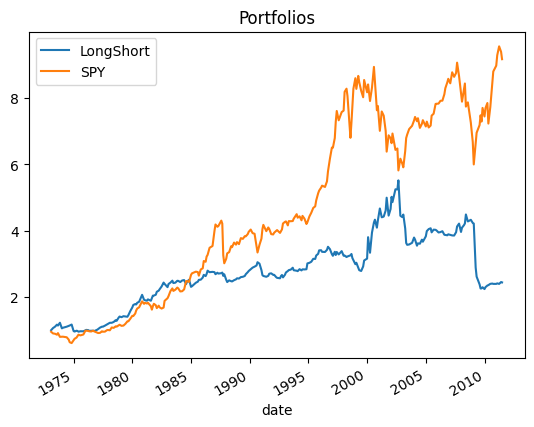

In [150]:
nav = metrics.nav()
nav.plot(title="Portfolios")

In [21]:
N = len(mkt)
Vt = (1 + mkt).prod()
G = Vt ** (12 / N) - 1
G

np.float64(0.04689413687521182)

In [78]:
non_numeric = rt_i.columns[rt_i.dtypes == 'object']
non_numeric

Index([10001, 10006, 10008, 10010, 10011, 10012, 10014, 10015, 10016, 10017,
       ...
       93422, 93423, 93426, 93428, 93429, 93430, 93432, 93433, 93434, 93436],
      dtype='int64', name='PERMNO', length=13469)

In [81]:
rt_i = rt_i.apply(pd.to_numeric, errors='coerce')
rt_i

PERMNO,10001,10006,10008,10010,10011,10012,10014,10015,10016,10017,...,93422,93423,93426,93428,93429,93430,93432,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
1972-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-12-29,NaN,-0.018041,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-31,NaN,-0.060367,NaN,NaN,NaN,NaN,-0.035714,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-28,NaN,-0.075978,NaN,NaN,NaN,NaN,-0.185185,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-30,NaN,0.110429,NaN,NaN,NaN,NaN,0.045455,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-30,NaN,-0.002762,NaN,NaN,NaN,NaN,-0.173913,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-31,NaN,-0.011634,NaN,NaN,NaN,NaN,-0.105263,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
